# ISM-FLOW Workshop 2: An introduction to SigMA

This notebook is intended for first-time users of the Significance Mode Analysis (SigMA) clustering algorithm. It demonstrates basic code functionality on the example dataset of a clustering selection in Vela-Puppis (Cantat-Gaudin+2017).

###  Modules + setup

In [2]:
# robust import setup (ohne starre parents[1])
import sys, pathlib

start = pathlib.Path.cwd()
repo = None
for up in [start, *start.parents]:
    if (up/'coordinate_transformations'/'sky_convert.py').exists() \
       or (up/'SigMA'/'coordinate_transformations'/'sky_convert.py').exists():
        repo = up
        break
assert repo, "Repo-Root mit (SigMA/)coordinate_transformations nicht gefunden."

# in sys.path eintragen (nur 1x)
p = str(repo)
if p not in sys.path:
    sys.path.insert(0, p)

# Import-Cache leeren falls vorher falscher Pfad geladen wurde
for m in list(sys.modules):
    if m.startswith(('coordinate_transformations','SigMA')):
        sys.modules.pop(m)
        
print("Import OK from repo:", repo)


Import OK from repo: /Users/laxman/projects/GitHub/Distant_SigMA


In [3]:
from pathlib import Path
import pandas as pd

repo = Path("/Users/laxman/projects/GitHub/Distant_SigMA")  # aus deiner OK-Zeile
fname = "Vela_clusters_DR3_preprocessed.csv"

# Datei im Repo suchen (falls Ordner/Unterstrich variieren)
hits = list(repo.rglob(fname))
print("Treffer:", *hits, sep="\n- ")
assert hits, f"{fname} nicht gefunden."

# ggf. jüngste nehmen
csv = max(hits, key=lambda p: p.stat().st_mtime)
use = ['ra','dec','parallax','X','Y','Z','v_a_lsr','v_d_lsr','label','distance']

df = pd.read_csv(csv, usecols=use)
df.head()


Treffer:
- /Users/laxman/projects/GitHub/Distant_SigMA/laxman_workspace/codes/ISM-FLOW-WS2/Vela_clusters_DR3_preprocessed.csv
- /Users/laxman/projects/GitHub/Distant_SigMA/DistantSigMA/Collab/ISM-FLOW-WS2/Vela_clusters_DR3_preprocessed.csv


,label,ra,dec,parallax,distance,X,Y,Z,v_a_lsr,v_d_lsr
0,3,119.534503,-45.289629,2.5518,391.880241,-67.308483,-381.887280,-56.584425,-9.259812,12.231144
1,3,117.478434,-41.361619,2.8974,345.137019,-83.825874,-331.653957,-45.808709,-7.282962,12.960175
2,3,117.383706,-41.167946,2.8569,350.029753,-86.225960,-336.075311,-46.252531,-8.473165,14.458632
3,3,115.778062,-42.446179,2.4887,401.816209,-94.921531,-385.052296,-64.659868,-9.041788,13.458839
4,3,119.258807,-43.488479,2.4041,415.956075,-83.360030,-403.829318,-54.703236,-10.489070,12.865119


In [4]:
# Python modules
import os
import pandas as pd
import seaborn as sns
import time, datetime

# SigMA modules
from coordinate_transformations.sky_convert import transform_sphere_to_cartesian

#### DistantSigMA modules
from DistantSigMA.DistantSigMA.clustering_routine import *
from DistantSigMA.DistantSigMA.PlotlyResults import plot
from DistantSigMA.DistantSigMA.cluster_simulations import calculate_std_devs
from DistantSigMA.DistantSigMA.scalefactor_sampling import lhc_lloyd

# Paths
output_path = "output/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

## Dataset

SigMA works on 5D astrometric data (and occasionally radial velocities, if available). Currently, one can cluster either in **Galactic cartesian coordinates** or in the **ICRS coordinate system**.

Necessary columns for **Galactic cartesian coordinates**:
- `['X', 'Y', 'Z', 'v_a_lsr', 'v_d_lsr']`

Necessary columns for **ICRS coordinate system**:
- full 5D astrometry columns: `['ra', 'dec', 'parallax', 'pmra', 'pmdec']`
- error columns for the astrometry (`'<variable>_error'`)
- correlation columns for the astrometry (`<variable1>_<variable2>_corr`)
- radial velocity columns `['radial_velocity', 'radial_velocity_error']`

*Note: The column names use the standard Gaia DR3 column names (not topcat DR3!).*


In [5]:
df = pd.read_csv("Vela_clusters_DR3_preprocessed.csv", usecols=['ra', 'dec', 'parallax','X', 'Y', 'Z', 'v_a_lsr', 'v_d_lsr', 'label', 'distance'])

df.head()

,label,ra,dec,parallax,distance,X,Y,Z,v_a_lsr,v_d_lsr
0,3,119.534503,-45.289629,2.5518,391.880241,-67.308483,-381.887280,-56.584425,-9.259812,12.231144
1,3,117.478434,-41.361619,2.8974,345.137019,-83.825874,-331.653957,-45.808709,-7.282962,12.960175
2,3,117.383706,-41.167946,2.8569,350.029753,-86.225960,-336.075311,-46.252531,-8.473165,14.458632
3,3,115.778062,-42.446179,2.4887,401.816209,-94.921531,-385.052296,-64.659868,-9.041788,13.458839
4,3,119.258807,-43.488479,2.4041,415.956075,-83.360030,-403.829318,-54.703236,-10.489070,12.865119


The dataframe loaded into the cell above has already been prepared with the right column names and the Cartesian coordinates have been added. The transformation between spherical and galactic cartesian coordinates can easily be done with the `coordinate_transformations.sky_convert.transform_sphere_to_cartesian()` function, in any case.

## 1. Basic clustering

First, we will take a look at the basic clustering capabilities of the algorithm, if broken down to the simplest level -- basically the **SigMA core functionality**. We are ignoring all the higher-level loop structures in the workflow for now, and will go through the steps of the left-most column (though not all of them are shown explicitly).

![bla](Workflow.png)


#### 1.1. Input dataset
For basic use of the algorithm, we will cluster in  **Galactic cartesian coordinates**, using the scaling relations inferred in Ratzenböck+2023a. These work best for the "sweet spot" for clustering around 150 - 300 pc. For this, we will restrict our sample to stars within this distance range.

The plot below shows the cluster distribution of the original dataset in this distance range.

In [7]:
df_near = df[df["distance"] < 350]

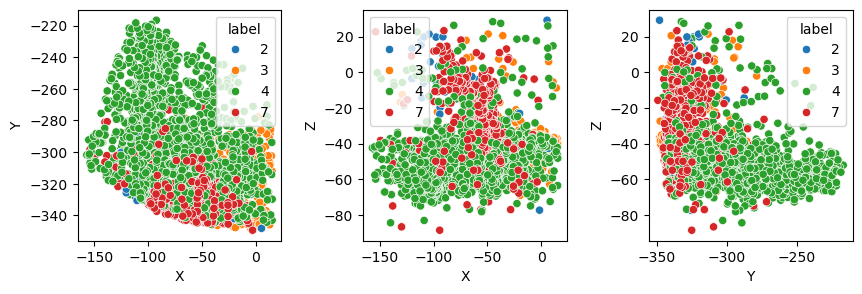

In [8]:
f,ax = plt.subplots(1,3, figsize=(10,3))

sns.scatterplot(data=df_near, x= "X", y="Y", hue="label", palette="tab10", ax=ax[0])
sns.scatterplot(data=df_near, x= "X", y="Z", hue="label", palette="tab10", ax=ax[1])
sns.scatterplot(data=df_near, x= "Y", y="Z", hue="label", palette="tab10", ax=ax[2])

plt.subplots_adjust(wspace=0.4)
plt.show()

#### 1.2. Scaling the 5D space

Here, we import the scaling information and generate a scale factor list based on the distance range of our input data. For now, we only want to use a single velocity scale, so we use the mean scaling factor `sf`. We also define our `cluster_features`, meaning the names of the astrometry columns which we would like use for clustering.

In [9]:
from SigMA.bayesian_velocity_scaling import scale_factors as sf_function

vel_scaling_info = np.load('bayesian_LR_data.npz')
x_sf, post_pred_sf = vel_scaling_info['x'], vel_scaling_info['posterior_predictive']

scale_factor_list = sf_function(x_sf, post_pred_sf, x_range=(df_near.distance.min(), df_near.distance.max()))
sf_mean = np.mean(scale_factor_list)  # We will use this value for now

sf_mean, scale_factor_list

FileNotFoundError: [Errno 2] No such file or directory: 'bayesian_LR_data.npz'

In [10]:
cluster_features = ['X', 'Y', 'Z', 'v_a_lsr', 'v_d_lsr']   # Cols for Galactic Cart. clustering

### 1.3. Setting up SigMA

In [7]:
# Parameters to vary
knn = 100
alpha = 0.05
bh_correction = True

In [8]:
# Fixed parameters that work out quite well
beta = 0.99
knn_initcluster_graph = 30

sigma_kwargs = dict(
    cluster_features=cluster_features,  # Columns to cluster on
    scale_factors={'vel': {'features': ['v_a_lsr', 'v_d_lsr'], 'factor': sf_mean}},  # Columns that will be scaled
    nb_resampling=0,  # Resampling - e.g., important for calculating stability of membership
    max_knn_density=knn+1,  # This need
    beta=beta,
    knn_initcluster_graph=knn_initcluster_graph,
)

In [9]:
%%time
# Initialize SigMA instance
clusterer = SigMA(
    data=df_near,
    **sigma_kwargs
)

CPU times: user 190 ms, sys: 5.49 ms, total: 196 ms
Wall time: 140 ms


### 1.4. Run SigMA

In [10]:
# Fit
st = time.time()
print('Start clustering...')
clusterer.fit(alpha=alpha, knn=knn, bh_correction=True)
labels= clusterer.labels_

delta_t = str(datetime.timedelta(seconds=time.time() - st)).split('.')[0]
print(f'Done! [took {delta_t}]. Found {np.unique(labels).size} clusters')

# Save point-wise density
rho = clusterer.weights_

Start clustering...
Performing gradient ascend using a 100-NN density estimation.
Updated significance threshold: 1.56e-03
Done! [took 0:00:01]. Found 6 clusters


In [11]:
ln = LabelEncoder().fit_transform(labels)  # Sets labels to 0-(N-1)
print(ln.shape)

df_near["SigMA_label"] =ln

(3189,)


/var/folders/z6/y4rdkpdx3vlbwtmngx04x_1w0000gp/T/ipykernel_1616/1452144583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_near["SigMA_label"] =ln


### 1.5. View the results

In [12]:
nmi(df_near.label, ln)

0.6446461822805851

In [13]:
plot(labels=ln, df=df_near, filename="VelaNear", output_pathname=output_path)

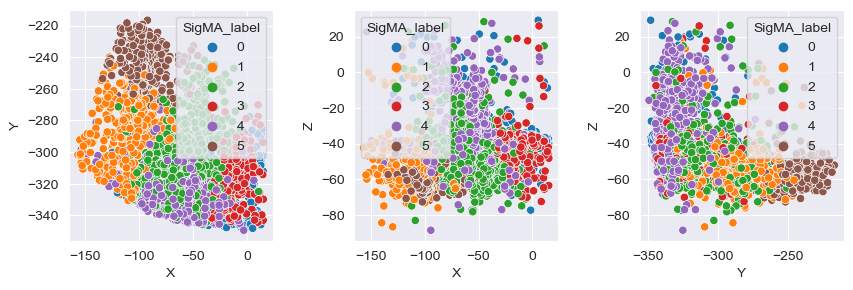

In [14]:
f,ax = plt.subplots(1,3, figsize=(10,3))

sns.scatterplot(data=df_near, x= "X", y="Y", hue="SigMA_label", palette="tab10", ax=ax[0])
sns.scatterplot(data=df_near, x= "X", y="Z", hue="SigMA_label", palette="tab10", ax=ax[1])
sns.scatterplot(data=df_near, x= "Y", y="Z", hue="SigMA_label", palette="tab10",ax=ax[2])

plt.subplots_adjust(wspace=0.4)
plt.show()

## 2. Consensus clustering

Since we do not know the underlying density of our dataset, but need to calculate it from the data themselves, it makes sense to use different density estimates for clustering, instead of making the results depend strongly on the chosen density parameterization, i.e., the number of nearest neighbors. At the same time, we will want to use different scaling parameters, instead of only the mean value, since we are covering a significant distance range as well.

Following the Workflow graph of SigMA, we will build two loops of clustering solutions:
- Outer loop: Density variation = different KNN values
- Inner loop: scaling factor variation

These solutions are then put into a consensus function, which assesses their similarity and performs a majority voting.
*Note:* A newer, more refined consensus approach is currently under construction -- see Nora's project.

In [15]:
def consensus_function(label_matrix: np.array, density_sum: np.array, df_fit: pd.DataFrame, file: str = None,
                       path: str = None, plotting: bool = True, field_comp: bool = True):
    """
    Function that takes the different labels created in a loop over either KNNs or scaling factors and makes a consensus
    solution.

    :param label_matrix: matrix holding the different results of the loop
    :param density_sum: the sum of the 1D density calculated in each step of the loop
    :param df_fit: input dataframe
    :param file: filename for the plot
    :param path: output path of the plot
    :param plotting: bool
    :return: consensus-labels and number of clusters found in the consensus solution
    """
    cc = ClusterConsensus(*label_matrix)
    labels_cc = cc.fit(density=density_sum, min_cluster_size=15)
    if field_comp:
        labels_cc_clean = LabelEncoder().fit_transform(labels_cc)-1
    else:
        labels_cc_clean = LabelEncoder().fit_transform(labels_cc)

    if plotting:
        plot(labels=labels_cc_clean, df=df_fit, filename=file, output_pathname=path)
    nb_consensus = np.unique(labels_cc_clean[labels_cc_clean > -1]).size


    return labels_cc_clean, nb_consensus

### 2.1. Set clustering parameters

In [16]:
# Cluster parameters
KNNs = [ 50, 100, 200]
a = 0.01
bh_corr = True


sigma_kwargs = dict(
    cluster_features= ['X', 'Y', 'Z', 'v_a_lsr', 'v_d_lsr'],   # Cols for Galactic Cart. clustering
    scale_factors={'vel': {'features': ['v_a_lsr', 'v_d_lsr'], 'factor': sf_mean}},
    nb_resampling=0,
    max_knn_density=max(KNNs) + 1,
    beta=0.99,
    knn_initcluster_graph=35)

### 2.2. Run SigMA in loops

In [17]:
# initialize SigMA with sf_mean
clusterer = SigMA(data=df_near, **sigma_kwargs)

# initialize array for density values (collect the rho_sums)
rhosum_list = []

# Initialize array for the outer Loop
results = np.empty(shape=(len(KNNs), len(df_near)))

# ---------------------------------------------------------
# Outer loop: KNN
for kid, knn in enumerate(KNNs):

    print(f"-- Current run with KNN = {knn} -- \n")

    # Initialize array for inner loop
    label_matrix = np.empty(shape=(len(scale_factor_list), len(df_near)))

    # initialize density-sum over all scaling factors
    rho_sum = np.zeros(df_near.shape[0], dtype=np.float32)

    # ---------------------------------------------------------
    # Inner loop: Scale factors
    for sf_id, sf in enumerate(scale_factor_list):
        # Set current scale factor
        scale_factors = {'vel': {'features': ['v_a_lsr', 'v_d_lsr'], 'factor': sf}}
        clusterer.set_scaling_factors(scale_factors)
        print(f"Performing clustering for scale factor {sf}...")

        # Fit
        clusterer.fit(alpha=a, knn=knn, bh_correction=bh_corr)
        label_array = clusterer.labels_

        # TODO: If we want to remove field stars, we would do it at this point in the loop
        label_matrix[sf_id, :] = label_array

        # density and X
        rho = clusterer.weights_
        rho_sum += rho
    # ---------------------------------------------------------
    rhosum_list.append(rho_sum)

    # Perform INNER consensus clustering (icc)
    labels_icc, n_icc = consensus_function(label_matrix, rho_sum, df_near,
                                                         f"KNN_{knn}_ICC_plot",
                                                         output_path,
                                                         plotting=True,
                                                         field_comp=False)
    results[kid, :] = labels_icc
    print(f":: Finished run for KNN={knn}! \n. Found {n_icc} final clusters.")

# ---------------------------------------------------------
# Perform OUTER consensus clustering (icc)
knn_mid = int(len(KNNs) / 2 - 1)  # Mean density is chosen for the outer consensus
df_save = df_near.copy()

# Perform consensus clustering on the c) and d) steps
labels_occ, n_occ = consensus_function(results, rhosum_list[knn_mid], df_near, f"OCC_plot", output_path, field_comp=False)

# save the labels in a csv file and plot the result
df_save["labels_final"] = labels_occ

-- Current run with KNN = 50 -- 

Creating k-d trees of resampled data sets...
Performing clustering for scale factor 3.163163163163163...
Performing gradient ascend using a 50-NN density estimation.
Updated significance threshold: 1.00e-05
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 6.086086086086086...
Performing gradient ascend using a 50-NN density estimation.
Updated significance threshold: 4.80e-03
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 7.967967967967968...
Performing gradient ascend using a 50-NN density estimation.
Updated significance threshold: 9.96e-04
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 9.52952952952953...
Performing gradient ascend using a 50-NN density estimation.
Updated significance threshold: 2.96e-03
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 10.93093093093093...
Performing gradient ascend using a

### 2.3. Look at the results

In [18]:
nmi(df_save.label, df_save.labels_final)

0.5990151891707847

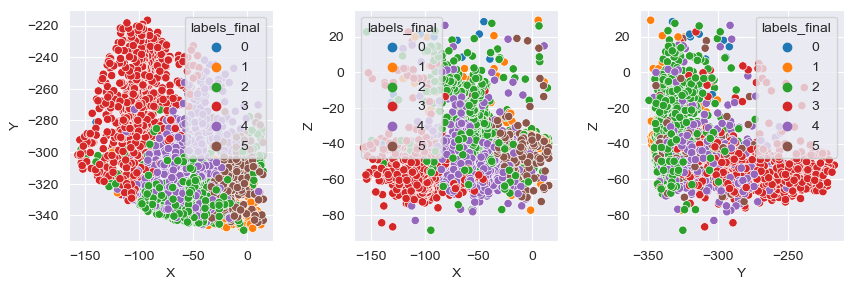

In [19]:
f,ax = plt.subplots(1,3, figsize=(10,3))

sns.scatterplot(data=df_save, x= "X", y="Y", hue="labels_final", palette="tab10", ax=ax[0])
sns.scatterplot(data=df_save, x= "X", y="Z", hue="labels_final", palette="tab10", ax=ax[1])
sns.scatterplot(data=df_save, x= "Y", y="Z", hue="labels_final", palette="tab10",ax=ax[2])

plt.subplots_adjust(wspace=0.4)
plt.show()

## 3. Clustering with Field stars

Until now, we have used a clustering solution that consisted only of actual cluster stars, so no field star removal was employed. In reality, distinguishing between field stars and actual cluster members is one of the most important steps in a clustering algorithm.

Currently, there are different options for removing field stars and spurious clusters available in SigMA. In the following, we can take a look at three different approaches

### 3.1. Generate data with field star contamination

In [20]:
df_field = pd.read_csv('Vela_field.csv', usecols=('ra', 'dec', 'parallax', 'pmra', 'pmdec'))
df_field["distance"] = 1000/df_field['parallax']
df_field["label"] = -1

field_xyz = transform_sphere_to_cartesian(ra=df_field.ra.to_numpy(),dec=df_field.dec.to_numpy(),parallax=df_field.parallax.to_numpy(),pmra=df_field.pmra.to_numpy(),pmdec=df_field.pmdec.to_numpy())
field_full = pd.concat([df_field, field_xyz], axis=1)

df_vela = pd.concat([df, field_full], axis=0)

In [21]:
vela_near = df_vela[df_vela.distance < 350]

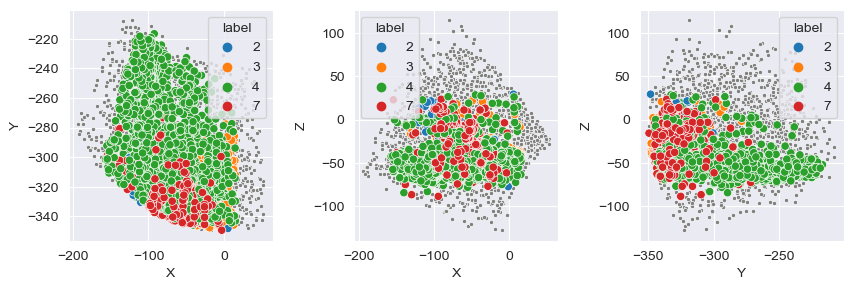

In [22]:
f,ax = plt.subplots(1,3, figsize=(10,3))

sns.scatterplot(data=vela_near[vela_near.label ==-1], x= "X", y="Y", marker =".", color="gray", ax=ax[0])
sns.scatterplot(data=vela_near[vela_near.label !=-1], x= "X", y="Y", hue="label", palette="tab10", ax=ax[0])

sns.scatterplot(data=vela_near[vela_near.label ==-1], x= "X", y="Z", marker =".", color="gray", ax=ax[1])
sns.scatterplot(data=vela_near[vela_near.label !=-1], x= "X", y="Z", hue="label", palette="tab10", ax=ax[1])

sns.scatterplot(data=vela_near[vela_near.label ==-1], x= "Y", y="Z", marker =".", color="gray", ax=ax[2])
sns.scatterplot(data=vela_near[vela_near.label !=-1], x= "Y", y="Z", hue="label", palette="tab10", ax=ax[2])

plt.subplots_adjust(wspace=0.4)
plt.show()

### 3.2. Set clustering parameters

In [25]:
# Cluster parameters
KNNs = [ 50, 100, 200]
a = 0.01
bh_corr = True


sigma_kwargs = dict(
    cluster_features= ['X', 'Y', 'Z', 'v_a_lsr', 'v_d_lsr'],   # Cols for Galactic Cart. clustering
    scale_factors={'vel': {'features': ['v_a_lsr', 'v_d_lsr'], 'factor': sf_mean}},
    nb_resampling=0,
    max_knn_density=max(KNNs) + 1,
    beta=0.99,
    knn_initcluster_graph=35)

### 3.3. Clustering with different removal strategies

In [26]:
# initialize SigMA with sf_mean
clusterer = SigMA(data=vela_near, **sigma_kwargs)

# initialize array for density values (collect the rho_sums)
rhosum_list = []

# Initialize array for the outer Loop
results_rfs = np.empty(shape=(len(KNNs), len(vela_near)))
results_rsc = np.empty(shape=(len(KNNs), len(vela_near)))
results_simple = np.empty(shape=(len(KNNs), len(vela_near)))

# ---------------------------------------------------------
# Outer loop: KNN
for kid, knn in enumerate(KNNs):

    print(f"-- Current run with KNN = {knn} -- \n")

    # Initialize array for inner loop
    label_matrix_rfs = np.empty(shape=(len(scale_factor_list), len(vela_near)))
    label_matrix_rsc = np.empty(shape=(len(scale_factor_list), len(vela_near)))
    label_matrix_simple = np.empty(shape=(len(scale_factor_list), len(vela_near)))

    # initialize density-sum over all scaling factors
    rho_sum = np.zeros(vela_near.shape[0], dtype=np.float32)

    # ---------------------------------------------------------
    # Inner loop: Scale factors
    for sf_id, sf in enumerate(scale_factor_list):
        # Set current scale factor
        scale_factors = {'vel': {'features': ['v_a_lsr', 'v_d_lsr'], 'factor': sf}}
        clusterer.set_scaling_factors(scale_factors)
        print(f"Performing clustering for scale factor {sf}...")

        # Fit
        clusterer.fit(alpha=a, knn=knn, bh_correction=bh_corr)
        label_array = clusterer.labels_

        # density and X
        rho, X = clusterer.weights_, clusterer.X
        rho_sum += rho

        # a) remove field stars
        nb_rfs = remove_field_stars(label_array, rho, label_matrix_rfs, sf_id)
        # b) remove spurious clusters
        nb_es, nb_rsc = extract_signal_remove_spurious(vela_near, label_array, rho, X, label_matrix_rsc, sf_id)
        # c) do new method
        nb_simple = extract_signal(label_array, clusterer, label_matrix_simple, sf_id)


    # ---------------------------------------------------------
    rhosum_list.append(rho_sum)

    # Perform INNER consensus clustering (icc)
    labels_icc_rfs, n_icc_rfs = consensus_function(label_matrix_rfs, rho_sum, vela_near,
                                                   f"rfs_KNN_{knn}_ICC",
                                                   output_path,
                                                   plotting=True)
    labels_icc_rsc, n_icc_rsc = consensus_function(label_matrix_rsc, rho_sum, vela_near,
                                                   f"rsc_KNN_{knn}_ICC",
                                                   output_path,
                                                   plotting=True)

    labels_icc_simple, n_icc_simple = consensus_function(label_matrix_simple, rho_sum, vela_near,
                                                         f"simple_KNN_{knn}_ICC",
                                                         output_path,
                                                         plotting=True)
    results_rfs[kid, :] = labels_icc_rfs

    results_rsc[kid, :] = labels_icc_rsc
    results_simple[kid, :] = labels_icc_simple

    print(f":: Finished run for KNN={knn}! \n. Found {n_icc_rfs} / {n_icc_rsc} / {n_icc_simple} final clusters.")

# ---------------------------------------------------------
# Perform OUTER consensus clustering (icc)
knn_mid = int(len(KNNs) / 2 - 1)  # Mean density is chosen for the outer consensus
df_save = vela_near.copy()
label_lists = [results_rfs, results_rsc, results_simple]

labels_occ, n_occ = zip(
    *(consensus_function(jl, rhosum_list[knn_mid], vela_near, f"{name}_OCC",
                         output_path) for jl, name in zip(label_lists, ["rfs", "rsc", "simple"])))
n_occ = list(n_occ)
labels_occ = list(labels_occ)

# save the labels in a csv file and plot the result
df_save["rsc"] = labels_occ[1]
df_save["rfs"] = labels_occ[0]
df_save["simple"] = labels_occ[2]

-- Current run with KNN = 50 -- 

Creating k-d trees of resampled data sets...
Performing clustering for scale factor 3.163163163163163...
Performing gradient ascend using a 50-NN density estimation.
Updated significance threshold: 1.00e-05
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 6.086086086086086...
Performing gradient ascend using a 50-NN density estimation.
Updated significance threshold: 1.00e-05
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 7.967967967967968...
Performing gradient ascend using a 50-NN density estimation.
Updated significance threshold: 9.96e-04
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 9.52952952952953...
Performing gradient ascend using a 50-NN density estimation.
Updated significance threshold: 2.96e-03
Creating k-d trees of resampled data sets...
Performing clustering for scale factor 10.93093093093093...
Performing gradient ascend using a

### 3.3. View results

In [27]:
print(nmi(df_save.label, df_save.rsc))

print(nmi(df_save.label, df_save.rfs))

print(nmi(df_save.label, df_save.simple))


0.43423753975202883
0.36692553184358195
0.3666904415642388


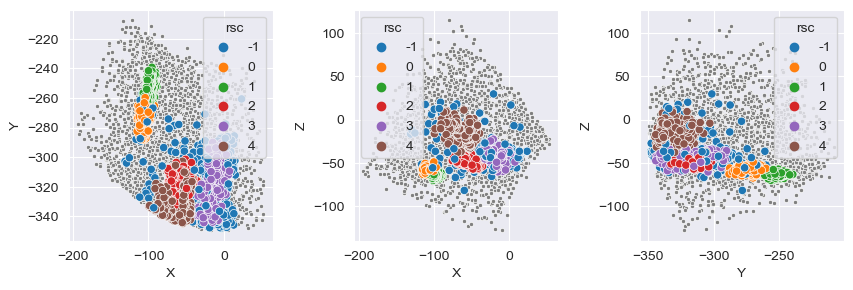

In [32]:
f,ax = plt.subplots(1,3, figsize=(10,3))

sns.scatterplot(data=df_save[df_save.rfs ==-1], x= "X", y="Y", marker =".", color="gray", ax=ax[0])
sns.scatterplot(data=df_save[df_save.rfs !=-1], x= "X", y="Y", hue="rsc", palette="tab10", ax=ax[0])

sns.scatterplot(data=df_save[df_save.rfs ==-1], x= "X", y="Z", marker =".", color="gray", ax=ax[1])
sns.scatterplot(data=df_save[df_save.rfs !=-1], x= "X", y="Z", hue="rsc", palette="tab10", ax=ax[1])

sns.scatterplot(data=df_save[df_save.rfs ==-1], x= "Y", y="Z", marker =".", color="gray", ax=ax[2])
sns.scatterplot(data=df_save[df_save.rfs !=-1], x= "Y", y="Z", hue="rsc", palette="tab10", ax=ax[2])

plt.subplots_adjust(wspace=0.4)
plt.show()

## 4. Clustering at large distances

## 5. Hierarchical clustering strategies